In [1]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import scipy.fft as fft
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy.stats import levy
from iminuit import Minuit
from scipy.optimize import curve_fit

## Initial conditions

In [2]:
'''
Good conditions - good ttcf and g2:

dim = 750 #[nm]
N = 35
radius = 10 #[nm]
bounds = (0 + radius, dim - radius)
diff = 1.0

#Detector parameters
s_dim = 2000 #[um]
dev = 50
roi_params = [100,300]

temp = 50

p_amount = int(N * 0.1) #How many particles to move
step_size = [5,10] #Size of step
''';

In [3]:
#sample parameters

dim = 500 #[nm]
N = 10
radius = 20 #[nm]
bounds = (0 + radius, dim - radius)
diff = 1.0

#Detector parameters
s_dim = 2000 #[um]
dev = 150
#roi_params = [int(dim / 10), int(dim / 3)]
roi_params = [80,100]

temp = [10,70]
p_amount = int(N) #How many particles to move
step_size = [6,10] #Size of step

n_frames = 100 #Amoun of images to generate

ttdt = np.linspace(0, 4.361e-05, n_frames-1)

In [4]:
conc = (np.pi * radius ** 2 * N) / (dim ** 2)
conc

0.05026548245743669

## Sample

In [5]:
def p_locs(N, dev, min_distance): #Create sample with normal distribution   
    positions = []
    center = [(bounds[0] + bounds[1]) / 2, (bounds[0] + bounds[1]) / 2]  # Center of the bounds

    while len(positions) < N:
        # Generate new position with a normal distribution centered at the center
        new_pos = np.random.normal(loc = center, scale = dev, size = (2,))
        
        # Ensure new position is within bounds
        if (bounds[0] + radius <= new_pos[0] <= bounds[1] - radius) and (bounds[0] + radius <=
                                                                         new_pos[1] <= bounds[1] - radius):
            # Check distances from existing particles
            if len(positions) > 0:
                distances = np.linalg.norm(new_pos - np.array(positions), axis=1)
                if np.all(distances >= min_distance):
                    positions.append(new_pos)
            else:
                positions.append(new_pos)

    return np.array(positions)

def sample(locs, radius): #Places the particle's location in a matrix - creating the sample matrix
    sample = np.zeros((dim, dim))
    for i in range(len(locs)):
        xx, yy = np.meshgrid(range(dim), range(dim))
        dist_squared = (xx - locs[:,0][i]) ** 2 + (yy - locs[:,1][i]) ** 2
        sample[dist_squared <= radius ** 2] = 1
    
    return sample

In [6]:
#Generate particle coordinates
particle_loc = p_locs(N, dev, 2 * radius)

#Generate sample matrix
init_sample = sample(particle_loc, radius)

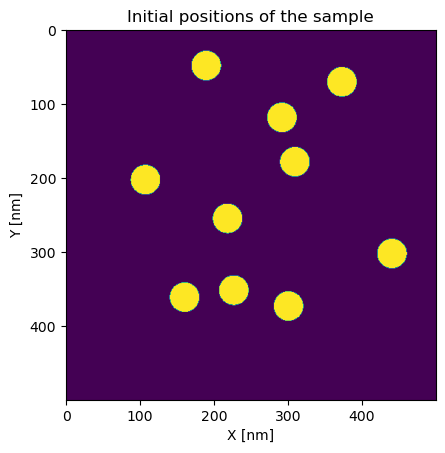

In [7]:
plt.imshow(init_sample) #Image of sample matrix
plt.xlabel('X [nm]')
plt.ylabel('Y [nm]')
plt.title('Initial positions of the sample')
plt.savefig('pics/init_pos_brown.png', dpi = 300)

## Brown Motion

In [8]:
def brown_motion_temp(ip, step, diff, bounds, p_amount, temperature, radius):
    # Set up
    old_positions = np.copy(ip)
    new_positions = np.copy(ip)  
    
    # Moving x amount of particles
    parts = np.random.randint(0, len(ip), p_amount)  # which particles to move

    for i in range(len(parts)):
        temp_factor = np.sqrt(abs(np.random.normal(temperature, scale = 10)))
        
        step_size = np.random.randint(int(step[0] + (temp_factor)), 
                                      int(step[1] + (temp_factor)) , 1)  # Step size of particle
        
        p_step = np.random.normal(scale = np.sqrt(2 * (diff) * step_size), size=2)  # Change coordinate
        new_positions[parts[i]] = ip[parts[i]] + p_step
        
        #print(step_size)

         #Boundary conditions - periodic
        if new_positions[parts[i]][0] + radius > bounds[1]:
            new_positions[parts[i]][0] = bounds[0] + radius
        elif new_positions[parts[i]][0] - radius < bounds[0]:
            new_positions[parts[i]][0] = bounds[1] - radius
        if new_positions[parts[i]][1] + radius > bounds[1]:
            new_positions[parts[i]][1] = bounds[0] + radius
        elif new_positions[parts[i]][1] - radius < bounds[0]:
            new_positions[parts[i]][1] = bounds[1] - radius
        
        
        #if new_positions[parts[i]][0] + radius > bounds[1]:
        #    new_positions[parts[i]][0] = bounds[1] - radius
        #elif new_positions[parts[i]][0] - radius < bounds[0]:
        #    new_positions[parts[i]][0] = bounds[0] + radius
        #if new_positions[parts[i]][1] + radius > bounds[1]:
        #    new_positions[parts[i]][1] = bounds[1] - radius
        #elif new_positions[parts[i]][1] + radius < bounds[0]:
        #    new_positions[parts[i]][1] = bounds[0] + radius
            
    # Collision avoidance, if their trajectories collide - they go back to their old position
    for i in range(len(new_positions)):
        for j in range(i + 1, len(new_positions)):
            dist = np.linalg.norm(new_positions[i] - new_positions[j])
            if dist == 0:
                dist = 2 * radius + 1
            elif dist < 2 * radius:
                new_positions[i] = old_positions[i]
                new_positions[j] = old_positions[j]

    return new_positions, old_positions


In [9]:
new_pos, old_pos = brown_motion_temp(particle_loc, step_size, diff, bounds, p_amount, temperature = 0, radius = 20)

brown_samp = sample(new_pos, radius) #generate image of altered sample

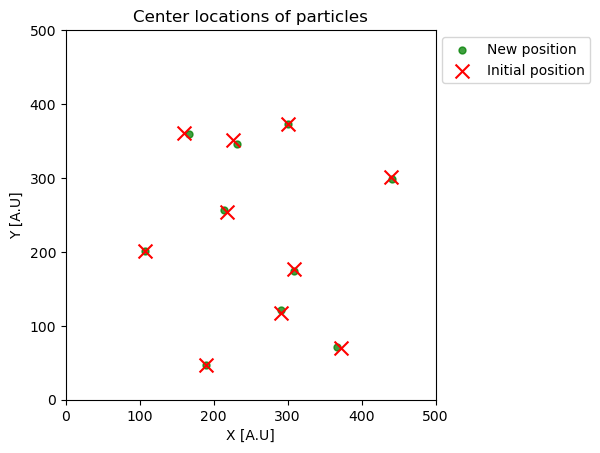

In [34]:
plt.scatter(new_pos[:,0], new_pos[:,1], color = 'green', alpha = 0.75, s = 100,
           label = 'New position', marker = '.')
plt.scatter(particle_loc[:,0], particle_loc[:,1], color = 'red', s = 100, 
           label = 'Initial position', marker = 'x' )
plt.xlabel('X [A.U]')
plt.ylabel('Y [A.U]')
plt.title('Center locations of particles')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.axis('scaled')
plt.xlim(0,500)
plt.ylim(0,500)
#plt.imshow(init_sample * 4, cmap = 'Reds', origin = 'lower')
#plt.imshow(brown_samp, alpha = 0.8, cmap = 'Greens', origin = 'lower')
#cbar = plt.colorbar()
#plt.axis('equal')
plt.savefig('pics/bm_scat.png', dpi = 300)

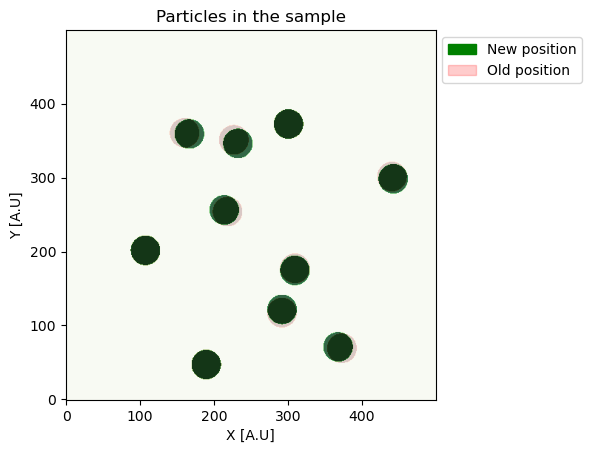

In [48]:
import matplotlib.patches as mpatches

plt.imshow(init_sample * 4, cmap = 'Reds', origin = 'lower')
plt.imshow(brown_samp, alpha = 0.8, cmap = 'Greens', origin = 'lower')
plt.xlabel('X [A.U]')
plt.ylabel('Y [A.U]')
plt.title('Particles in the sample')
patches = [mpatches.Patch(color='g', label = 'New position'), mpatches.Patch(color = 'r', alpha = 0.2, label = 'Old position')]
plt.legend(handles = patches, loc = 'upper left', bbox_to_anchor=(1, 1))
#cbar = plt.colorbar()
plt.savefig('pics/bm_imsh.png', dpi = 300)

In [12]:
def frame_generator_brown_temp(particle_loc, n_frames, temp):
    n = 0
    il = np.copy(particle_loc) #copy initial locations
    nl = [] #new locations
    temps = np.linspace(temp[0], temp[1], n_frames) #temp increase
    #temps = tt
    #rad = np.linspace(radius + (int(temps[0]) / 10), radius + (int(temps[-1]) / 10), n_frames) #radius increase
    rad = np.linspace(radius, radius, n_frames)
    
    while n < n_frames: # N amount of new locations
        new_l, old_l = brown_motion_temp(il, step_size, diff, # Brown motion with temp/radius increase
                                         bounds, p_amount, temps[n], rad[n])
        nn = np.vstack(new_l)
        nl.append(nn)
        il = nn #make new locations initial locations for next step
        n += 1
        
    
    frames = []
    for i in range(len(nl)):
        fr = sample(nl[i], rad[i])
        frames.append(fr)
    return frames, temps

In [13]:
%%time
frames_t, temps = frame_generator_brown_temp(particle_loc, n_frames, temp) # Amount of frames, 
                                                                        #temp_min, temp_max

CPU times: user 837 ms, sys: 75.1 ms, total: 912 ms
Wall time: 920 ms


In [14]:
def animation(frames, temps, show = True):
    if show == True:
        num_frames = len(frames)
        fig, ax = plt.subplots()
        im = ax.imshow(frames[0], cmap='viridis')
        temp_text = ax.text(0.05, 0.95, '', transform = ax.transAxes, 
                              color = 'white', fontsize = 12, ha = 'left', va = 'top')
        #rad_text = ax.text(0.1, 0.95, '', transform = ax.transAxes,
        #                      color = 'white', fontsize = 12, ha = 'left', va = 'top')
        
        def update(frame):
            im.set_array(frames[frame]) 
            temp_text.set_text(f'Temperature: {np.round(temps[frame], 2)} K')
            #rad_text.set_text(f'Radius: {np.round(rad[frame], 2)} nm')
            return [im, temp_text]
    
        ani = FuncAnimation(fig, update, frames=num_frames, interval=150, blit=True)
        return HTML(ani.to_jshtml())
    else:
        return plt.imshow(frames[0])

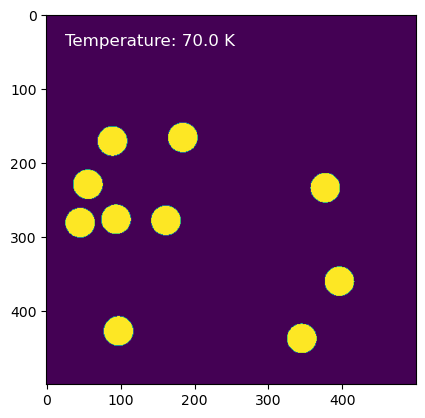

In [15]:
animation(frames_t, temps, show = True)

## Beam

In [16]:
#---------Defining image extents---------# 
pixelspace = dim/2                                                # in units of pixels
pixel_extent = [-pixelspace, pixelspace, -pixelspace, pixelspace]

sample_pixel_size = dim * 10e-9 #Dim in [nm] to [m]
realspace = (sample_pixel_size * (dim/2))                         # [currently m]
real_extent = [-realspace, realspace, -realspace, realspace]

recipspace = (2 * np.pi / realspace)                               # in units of 'a' [currently AA]
recip_extent = [-recipspace, recipspace, -recipspace, recipspace]

In [17]:
# Define sample parameters
pixel_size = 1 # Pixel size
sample_detector_distance = 8e6  # Sample-detector distance 
wavelength = 1 # Wavelength in aa

# Define scattering vector components (in reciprocal space)
ny, nx = init_sample.shape
qy, qx = np.meshgrid(np.fft.fftfreq(ny, pixel_size), np.fft.fftfreq(nx, pixel_size), indexing='ij')
q = np.sqrt(qx ** 2 + qy ** 2)

# Calculate scattering intensity
sc_intens = np.abs(fft.fft2(init_sample)) ** 2
sc_intens_q = np.fft.fftshift(np.fft.fft2(init_sample))

# XFEL beam
beam_profile = np.exp(- (q ** 2) / (4 * (1 / wavelength) ** 2))

# Simulate beam-sample interaction
intens = fft.fftshift(fft.ifft2(fft.fft2(sc_intens) * fft.fft2(beam_profile)))
intens_q = fft.fftshift(fft.ifft2(fft.fft2(sc_intens_q) * fft.fft2(beam_profile)))

# Generate speckle pattern 
spek = np.abs(intens)**2
speq = np.abs(intens_q)**2

In [18]:
q_extent = [qx.min(), qx.max(), qy.min(), qy.max()]
arrq = np.linspace(0, qx.max(), n_frames)

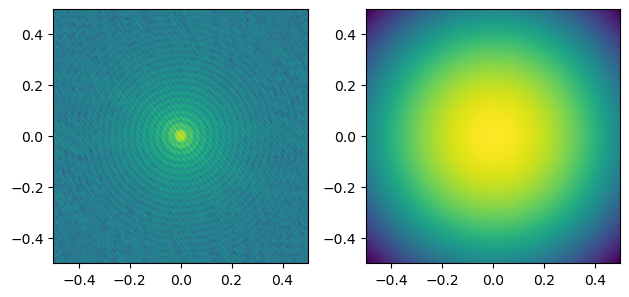

In [19]:
f, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(np.log(speq), extent = q_extent)
#ax1.title('2-D sample SAXS pattern')
#plt.xlim(-0.0001,0.0001)
#plt.ylim(-0.0001,0.0001)
#ax1.colorbar()

ax2.imshow(spek, extent = q_extent)
plt.tight_layout()

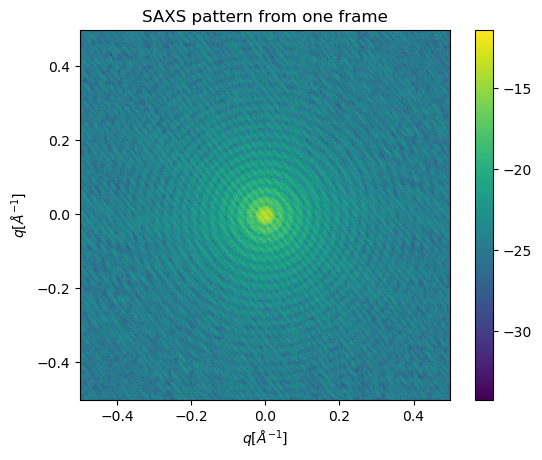

In [20]:
plt.imshow(np.log(speq), extent = q_extent)
plt.title('SAXS pattern from one frame')
plt.xlabel(r'$q [Å^{-1}]$')
plt.ylabel(r'$q [Å^{-1}]$')
plt.colorbar()
plt.savefig('pics/one_saxs_sim.png', dpi = 300)

In [21]:
def speck_q(frames): #Function for creating scattered frames 
    spekls = []
    speqls = []
    for i in range(len(frames)):
        sp = frames[i] 

        ny, nx = sp.shape
        qy, qx = np.meshgrid(np.fft.fftfreq(ny, pixel_size), np.fft.fftfreq(nx, pixel_size), indexing='ij')
        q = np.sqrt(qx**2 + qy**2)


        sc_intens = np.abs(fft.fft2(sp))**2
        sc_intens_q = np.fft.fftshift(np.fft.fft2(sp))


        beam_profile = np.exp(-(q**2) / (4 * (1 / wavelength)**2))


        intens = fft.fftshift(fft.ifft2(fft.fft2(sc_intens) * fft.fft2(beam_profile)))
        intens_q = fft.fftshift(fft.ifft2(fft.fft2(sc_intens_q) * fft.fft2(beam_profile)))


        spek = np.abs(intens)**2
        speq = np.abs(intens_q)**2

        spekls.append(spek)
        speqls.append(speq)

    return spekls, speqls

In [22]:
speks, speqs = speck_q(frames_t)

KeyboardInterrupt: 

In [ ]:
plt.imshow(np.log(np.mean(speqs, axis = 0)), extent = q_extent)
plt.title('Average SAXS pattern')
plt.xlabel(r'$q [Å^{-1}]$')
plt.ylabel(r'$q [Å^{-1}]$')
plt.colorbar()
plt.savefig('pics/avg_saxs_sim.png', dpi = 300)

## Azimuthal Integration

In [ ]:
#Azimuthal integration
import math as m
image = (speqs[0])

center = (dim/2, dim/2)
d = m.floor(np.sqrt(center[0] ** 2 + center[1] ** 2))

centered = np.meshgrid(np.arange(dim) - center[0], np.arange(dim) - center[1])
rad = np.sqrt((centered[0] ** 2) + (centered[1] ** 2))

r = np.linspace(1, int(center[0]) + 1, int(center[0]))

d = lambda r : image[(rad >= r - 0.5) & (rad < r + 0.5)].mean()


In [ ]:
def azimuthal_int(image):
    im = image
    center = (dim/2, dim/2)
    d = m.floor(np.sqrt(center[0] ** 2 + center[1] ** 2))
    
    centered = np.meshgrid(np.arange(dim) - center[0], np.arange(dim) - center[1])
    rad = np.sqrt((centered[0] ** 2 + (centered[1] ** 2)))
                  
    r = np.linspace(1, int(center[0]) + 1, int(center[0]))
                  
    d = lambda r : im [(rad >= r - 0.5) & (rad < r + 0.5)].mean()
                  
    mean_d = np.vectorize(d)(r)
    
    return mean_d

In [ ]:
azz = azimuthal_int(speqs[0])
from scipy.signal import find_peaks

peaks, _ = find_peaks(azz, distance = 30)
peaks
p_x = np.linspace(0,len(azz),len(peaks))

In [ ]:
pp = np.linspace(0, int(dim/2), int(dim/2))

In [ ]:
rois = []
for i in range(1, len(peaks)):
    l_roi = pp[peaks[i]] - 5
    u_roi = pp[peaks[i]] + 5
    rois.append([int(l_roi), int(u_roi)])

rois

In [ ]:
q_azim = np.linspace(0, qx.max(), len(azimuthal_int(speqs[0])))

In [ ]:
plt.plot(q_azim, azimuthal_int(np.mean(speqs, axis = 0)), label = 'Azimuthal integration')
plt.scatter(q_azim[peaks[2:]], azz[peaks[2:]], c = 'orange', label = 'Fitted peaks')
plt.yscale('log')
plt.title('Azimuthal integration of the mean SAXS pattern')
plt.xlabel(r'$q [Å^{-1}]$')
plt.ylabel('Intensity [A.U]')
plt.legend()
#plt.savefig('pics/azim_peaks.png', dpi = 300)
#plt.xscale('log')

In [ ]:
mean_d = np.vectorize(d)(r)

In [ ]:
def sinc_func(x, amplitude, frequency, phase, offset):
    return amplitude  * np.sinc(frequency * (x - phase)) + offset

def chi2_sinc(amplitude, frequency, phase, offset):
    model = sinc_func(q_azim, amplitude, frequency, phase, offset)
    return np.sum(((mean_d - model) / np.std(mean_d)) ** 2)

def osc_dec(x, A, lambda_, omega, phi):
    return A * np.exp(-lambda_ * x) * np.cos(omega * x + phi)

def chi2_od(A, lambda_, omega, phi):
    model = osc_dec(q_azim, A, lambda_, omega, phi)
    return np.sum(((mean_d - model) / np.std(mean_d)) ** 2)

azim_fit = Minuit(chi2_sinc, amplitude = max(mean_d), frequency = 50, phase = 10, offset = min(mean_d))
azim_fit.migrad()

#fit_od = Minuit(chi2_od, A = 1, lambda_ = 1, omega = 1, phi = 1)
#fit_od.migrad()

In [ ]:
amp, freq, phase, off = azim_fit.values
y_azim = sinc_func(q_azim, amp, freq, phase, off)

In [ ]:
plt.scatter(q_azim, (mean_d), s = 5)
plt.plot(q_azim, (y_azim))
plt.yscale('log')
#plt.plot(q_azim, y_od)

plt.xscale('log')
#plt.ylim(-0.11e-7, 0.2e-7)

## Creating ROIs

In [ ]:
#Creating a ROI



x, y = np.ogrid[:dim, :dim]
c_dist = np.sqrt((x - center[0]) ** 2 + (y - center[1]) ** 2)
mask = (c_dist <= roi_params[1]) & (c_dist >= roi_params[0])

c_roi = np.zeros_like(speqs[0])
c_roi[mask] = speqs[0][mask]

In [ ]:
#Function to calculate get rois

def roi(upper, lower, speqs):
    roi = [upper, lower]
    
    x, y = np.ogrid[:dim, :dim]
    c_dist = np.sqrt((x - center[0]) ** 2 + (y - center[1]) ** 2)
    mask = (c_dist <= roi[1]) & (c_dist >= roi[0])
    
    rois = []

    for i in range(len(speqs)):
        mat = np.zeros_like(speqs[i])
        mat[mask] = speqs[i][mask]
        rois.append(mat[mask])
        
    return np.array(rois)

In [ ]:
rr = []
for i in range(len(rois)):
    rr.append(roi(rois[i][0], rois[i][1], speqs))

ones = np.ones(np.shape(speqs))
same = ones * speqs[0]

## TTCF

In [ ]:
w = roi(roi_params[0], roi_params[1], (speqs))

In [ ]:
ttcf = np.matmul(w, w.T)

In [ ]:
plt.figure(1, figsize = (7,7))
plt.imshow(ttcf/ttcf.max(), cmap = 'jet', origin = 'lower')
plt.colorbar()
plt.title('TTCF for N = {}, R = {}, step_size ={}, parts = {}'.format(N,radius, 
                                                                      step_size, p_amount))
#print(np.mean(ttcf))
plt.xlabel(r'$T_{1}$ [A.U]')
plt.ylabel(r'$T_{2}$ [A.U]')
#plt.savefig('pics/ttcf_1000_frame

## G2

In [ ]:
def get_cf(darr,skip_last=0):
    return np.array([np.nanmean(np.diagonal(darr,offset=i)) for i in range(1,len(darr)-skip_last)])

def e_decay(dt,Gm,beta,off):
    g1 = np.exp(-Gm*dt)
    g2 = beta*g1**2+off
    return g2

g2 = get_cf(ttcf/ttcf.max())
t_steps = np.linspace(0, len(g2), len(g2))

y_err = np.std(g2) 

In [ ]:
def chi2(Gm,beta,off):
    y_exp = e_decay(t_steps,Gm,beta,off)
    chi2 = np.sum(((g2 - y_exp) / np.std(g2))**2)
    return chi2

In [ ]:
def g2_fit(g2):
    gm = []
    b = []
    k = []
    chi = []
    unc = []

    def chi2(Gm,beta,off):
        y_exp = e_decay(ttdt,Gm,beta,off)
        chi2 = np.sum(((g2[i] - y_exp) / np.std(g2[i]))**2)
        return chi2
    
    for i in range(len(g2)):
        fit = Minuit(chi2, Gm = 5, beta = g2[i][0], off = min(g2[i]))
        fit.migrad()
        gg, bb, of = fit.values
        gm.append(gg)
        b.append(bb)
        k.append(of)
        chi.append(fit.fval)
        unc.append(fit.errors)
    return gm, b, k, chi, unc
        

In [ ]:
fit = Minuit(chi2, beta = g2[0], Gm = 5, off = min(g2))
fit.migrad()

In [ ]:
Gm, beta, off = fit.values
gm_unc, beta_unc, off_unc = fit.errors
fit_curve = e_decay(t_steps, Gm, beta, off)
chi2_val = np.round(fit.fval,2)

In [ ]:
plt.figure(1, figsize = (7,7))

plt.scatter(t_steps, get_cf(ttcf/ttcf.max()), s = 10,
           label = 'g2', alpha = 0.5)
            
plt.plot(fit_curve, color = 'b', alpha = 1, label = 'g2_fit', ls = '-.')
plt.ylabel('g2 - 1')
plt.xlabel(r'$\Delta t \quad [A.U]$')
plt.text(x = len(g2) - len(g2)/2, y = g2[-1] + 0.05, s = r'$\chi^{} = {}$'.format(2,chi2_val));
#plt.axvline(x = 50)
plt.xscale('log')
plt.legend()


In [ ]:
fit_params = ['Gm: Decay rate -- 1/Gm','beta: Contrast','off: Offset']
for i in range(len(fit.values)):
    print(fit_params[i],np.round(fit.values[i],4))

## Multiple ROIs

In [ ]:
rois = []
q_vals = []
for i in range(1, len(peaks)):
    l_roi = pp[peaks[i]] - 5
    u_roi = pp[peaks[i]] + 5
    rois.append([int(l_roi), int(u_roi)])
    q_val = [q_azim[int(l_roi)], q_azim[int(u_roi)]]
    q_vals.append(q_val)

In [ ]:
rr = []
for i in range(len(rois)):
    rr.append(roi(rois[i][0], rois[i][1], speqs))

In [ ]:
for i in range(len(rr)):
    plt.figure(i)
    plt.imshow(np.matmul(rr[i], rr[i].T), cmap = 'jet', origin = 'lower')
    plt.title('q_range:_{}'.format(q_vals[i]))
    plt.colorbar()
    plt.tight_layout()

In [ ]:
g2s = []
for i in range(len(rr)):
    ttcf = np.matmul(rr[i], rr[i].T)
    g = get_cf(ttcf / ttcf.max())
    g2s.append(g)

In [ ]:
for i in range(2,6):
    plt.scatter(ttdt[:99],g2s[i], label = '{}'.format(i), s = 5)
    plt.xscale('log')
plt.legend()

In [ ]:
gms, bs, ks, uncs, chis = g2_fit(g2s)

In [ ]:
for i in range(2,6):
    plt.scatter(ttdt,g2s[i], label = '{}'.format(i), s = 5)
    plt.xscale('log')
    plt.plot(ttdt, e_decay(ttdt, gms[i], bs[i], ks[i]), label = 'fit {}'.format(i))
plt.legend()

In [ ]:
1/np.array(gms)

In [ ]:
qqdq = np.array(q_vals)[:,0]

In [ ]:
plt.scatter(qqdq[2:]**2, gms[2:])

In [ ]:
for i in range(len(gms)):
    #plt.scatter(ttdt,g2s[i], label = '{}'.format(i), s = 5)
    plt.xscale('log')
    plt.plot(ttdt, e_decay(ttdt, gms[i], bs[i], ks[i]), label = 'fit {}'.format(i))
plt.legend()